# 25l: Opponent Inference Foundation

**Goal**: Build likelihood tables for Bayesian opponent modeling.

**Method**: 
1. From solved games, extract P(play X | holding Y)
2. Build likelihood ratios for inference: "Given they played X, what's the probability they hold Y?"
3. Foundation for particle filter opponent modeling during live play

**Key Formula**:
```
P(holding Y | played X) = P(played X | holding Y) * P(holding Y) / P(played X)
```

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns

from forge.analysis.utils import viz
from forge.oracle import schema, tables
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. State Decoding Helpers

In [2]:
def depth_from_state(state: int) -> int:
    """Dominoes remaining (28 = start, 0 = end)."""
    domino_mask = state & 0x0FFFFFFF
    return bin(domino_mask).count('1')

def trick_len_from_state(state: int) -> int:
    """Cards played in current trick (0-3)."""
    return (state >> 30) & 0x3

def leader_from_state(state: int) -> int:
    """Who led this trick (0-3)."""
    return (state >> 28) & 0x3

def current_player(state: int) -> int:
    """Whose turn it is (0-3)."""
    trick_len = trick_len_from_state(state)
    leader = leader_from_state(state)
    return (leader + trick_len) % 4

def remaining_dominoes(state: int) -> set:
    """Set of domino IDs still in play."""
    mask = state & 0x0FFFFFFF
    return {i for i in range(28) if (mask >> i) & 1}

def domino_name(d_id: int) -> str:
    """Human-readable domino name."""
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

print("Helpers loaded")

Helpers loaded


## 2. Extract Play Observations

For each state where a player acts optimally, record:
- Which domino they played (the optimal action)
- What other dominoes they held at the time

In [3]:
# Find shard files
shard_files = sorted(Path(DATA_DIR).glob("*.parquet"))
print(f"Found {len(shard_files)} shard files")

N_SHARDS = 10  # Use more shards for better statistics
SAMPLE_PER_SHARD = 100_000

sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards")

Found 1124 shard files
Using 10 shards


In [4]:
# Count co-occurrences:
# play_given_hold[played_domino][held_domino] = count of times played X while holding Y
# hold_counts[held_domino] = total times holding Y when acting
# play_counts[played_domino] = total times played X

play_given_hold = defaultdict(lambda: defaultdict(int))
hold_counts = defaultdict(int)
play_counts = defaultdict(int)
total_observations = 0

for shard_file in tqdm(sample_files, desc="Processing shards"):
    # Extract seed from filename
    parts = shard_file.stem.split('_')
    seed = int(parts[1])
    
    hands = deal_from_seed(seed)
    
    # Load shard
    table = pq.read_table(shard_file, columns=['state', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    df = table.to_pandas()
    
    # Sample
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=42)
    
    states = df['state'].values
    q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    q_values = df[q_cols].values.astype(np.float32)
    q_values[q_values == -128] = -np.inf
    
    for i in range(len(df)):
        state = states[i]
        qs = q_values[i]
        
        if np.all(np.isinf(qs)):
            continue
        
        # Get current player and their hand
        player = current_player(state)
        remaining = remaining_dominoes(state)
        player_hand = [d for d in hands[player] if d in remaining]
        
        if len(player_hand) < 2:  # Need at least 2 dominoes to infer
            continue
        
        # Find optimal action (local index)
        optimal_local = int(np.argmax(qs))
        
        if optimal_local >= len(player_hand):
            continue  # Safety check
        
        # Get the played domino
        played_domino = player_hand[optimal_local]
        
        # Record: "played X while holding Y" for all Y in hand
        for held_domino in player_hand:
            hold_counts[held_domino] += 1
            if held_domino != played_domino:
                # Record that we played X while also holding Y
                play_given_hold[played_domino][held_domino] += 1
        
        play_counts[played_domino] += 1
        total_observations += 1
    
    del df, table

print(f"\nTotal observations: {total_observations:,}")

Processing shards:   0%|          | 0/10 [00:00<?, ?it/s]

Processing shards:  10%|█         | 1/10 [00:01<00:14,  1.62s/it]

Processing shards:  20%|██        | 2/10 [00:02<00:11,  1.45s/it]

Processing shards:  30%|███       | 3/10 [00:09<00:26,  3.83s/it]

Processing shards:  40%|████      | 4/10 [00:17<00:32,  5.44s/it]

Processing shards:  50%|█████     | 5/10 [00:19<00:20,  4.11s/it]

Processing shards:  60%|██████    | 6/10 [00:23<00:16,  4.10s/it]

Processing shards:  70%|███████   | 7/10 [00:25<00:10,  3.62s/it]

Processing shards:  80%|████████  | 8/10 [00:29<00:06,  3.45s/it]

Processing shards:  90%|█████████ | 9/10 [00:32<00:03,  3.44s/it]

Processing shards: 100%|██████████| 10/10 [00:36<00:00,  3.55s/it]

Processing shards: 100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Total observations: 415,789


## 3. Compute Conditional Probabilities

For Bayesian inference, we need:
- **P(play X | hold Y)**: Probability of playing X given you hold Y (our main output)
- **P(hold Y | play X)**: Inverse - "given they played X, what's P they hold Y?"

In [5]:
# Build probability matrices
n_dominoes = 28

# P(play X | hold Y) - rows = played, cols = held
p_play_given_hold = np.zeros((n_dominoes, n_dominoes))

for played in range(n_dominoes):
    for held in range(n_dominoes):
        if played == held:
            continue  # Can't compute P(play X | hold X) this way
        if hold_counts[held] > 0:
            # P(play X | hold Y) = count(play X and hold Y) / count(hold Y)
            p_play_given_hold[played, held] = play_given_hold[played][held] / hold_counts[held]

print(f"P(play X | hold Y) matrix shape: {p_play_given_hold.shape}")
print(f"Non-zero entries: {np.sum(p_play_given_hold > 0):,}")
print(f"Max probability: {p_play_given_hold.max():.4f}")

P(play X | hold Y) matrix shape: (28, 28)
Non-zero entries: 698
Max probability: 0.1377


In [6]:
# Compute marginal play probabilities: P(play X)
p_play = np.array([play_counts[d] / total_observations for d in range(n_dominoes)])

# Compute marginal hold probabilities: P(hold Y)
total_holds = sum(hold_counts.values())
p_hold = np.array([hold_counts[d] / total_holds for d in range(n_dominoes)])

print("Marginal play probabilities (top 5):")
top_played = np.argsort(p_play)[::-1][:5]
for d in top_played:
    print(f"  {domino_name(d)}: {p_play[d]*100:.2f}%")

print("\nMarginal hold probabilities (top 5):")
top_held = np.argsort(p_hold)[::-1][:5]
for d in top_held:
    print(f"  {domino_name(d)}: {p_hold[d]*100:.2f}%")

Marginal play probabilities (top 5):
  0-0: 7.66%
  3-1: 5.69%
  2-2: 5.42%
  1-0: 5.06%
  3-2: 4.58%

Marginal hold probabilities (top 5):
  3-3: 4.53%
  4-4: 4.45%
  0-0: 4.36%
  3-1: 4.34%
  3-2: 4.22%


## 4. Likelihood Ratios for Inference

The key quantity for Bayesian updating is the **likelihood ratio**:

```
LR(Y | X) = P(play X | hold Y) / P(play X | not hold Y)
```

If LR > 1: Playing X suggests they hold Y  
If LR < 1: Playing X suggests they don't hold Y  
If LR = 1: No information gained

In [7]:
# We need P(play X | NOT hold Y)
# Count observations where player doesn't hold Y
not_hold_counts = {d: total_observations - hold_counts[d] for d in range(n_dominoes)}

# Count play X when NOT holding Y
play_given_not_hold = defaultdict(lambda: defaultdict(int))

# Reprocess to get these counts
for shard_file in tqdm(sample_files[:5], desc="Computing NOT-hold counts"):  # Subset for speed
    parts = shard_file.stem.split('_')
    seed = int(parts[1])
    hands = deal_from_seed(seed)
    
    table = pq.read_table(shard_file, columns=['state', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    df = table.to_pandas()
    
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=42)
    
    states = df['state'].values
    q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    q_values = df[q_cols].values.astype(np.float32)
    q_values[q_values == -128] = -np.inf
    
    for i in range(len(df)):
        state = states[i]
        qs = q_values[i]
        
        if np.all(np.isinf(qs)):
            continue
        
        player = current_player(state)
        remaining = remaining_dominoes(state)
        player_hand = set(d for d in hands[player] if d in remaining)
        
        if len(player_hand) < 2:
            continue
        
        optimal_local = int(np.argmax(qs))
        player_hand_list = [d for d in hands[player] if d in remaining]
        
        if optimal_local >= len(player_hand_list):
            continue
        
        played_domino = player_hand_list[optimal_local]
        
        # Record: played X while NOT holding Y
        for not_held in range(n_dominoes):
            if not_held not in player_hand:
                play_given_not_hold[played_domino][not_held] += 1
    
    del df, table

print("NOT-hold counts computed")

Computing NOT-hold counts:   0%|          | 0/5 [00:00<?, ?it/s]

Computing NOT-hold counts:  20%|██        | 1/5 [00:01<00:07,  1.91s/it]

Computing NOT-hold counts:  40%|████      | 2/5 [00:03<00:05,  1.68s/it]

Computing NOT-hold counts:  60%|██████    | 3/5 [00:10<00:08,  4.02s/it]

Computing NOT-hold counts:  80%|████████  | 4/5 [00:18<00:05,  5.71s/it]

Computing NOT-hold counts: 100%|██████████| 5/5 [00:20<00:00,  4.37s/it]

Computing NOT-hold counts: 100%|██████████| 5/5 [00:20<00:00,  4.11s/it]

NOT-hold counts computed


In [8]:
# Compute likelihood ratios
likelihood_ratios = np.ones((n_dominoes, n_dominoes))  # Default LR = 1 (no info)

for played in range(n_dominoes):
    for held in range(n_dominoes):
        if played == held:
            continue
        
        # P(play X | hold Y)
        p_play_if_hold = p_play_given_hold[played, held]
        
        # P(play X | NOT hold Y) - estimate from counts
        not_hold_total = sum(1 for d in play_given_not_hold[played].values())
        if not_hold_total > 0 and play_given_not_hold[played][held] > 0:
            p_play_if_not_hold = play_given_not_hold[played][held] / not_hold_counts[held]
        else:
            p_play_if_not_hold = p_play[played]  # Use marginal as fallback
        
        if p_play_if_not_hold > 0:
            likelihood_ratios[played, held] = p_play_if_hold / p_play_if_not_hold

# Clip extreme values for numerical stability
likelihood_ratios = np.clip(likelihood_ratios, 0.01, 100)

print(f"Likelihood ratio matrix shape: {likelihood_ratios.shape}")
print(f"Max LR: {likelihood_ratios.max():.2f}")
print(f"Min LR: {likelihood_ratios.min():.4f}")
print(f"Median LR: {np.median(likelihood_ratios):.2f}")

Likelihood ratio matrix shape: (28, 28)
Max LR: 8.65
Min LR: 0.0100
Median LR: 1.21


## 5. Find Informative Play Patterns

In [9]:
# Find most informative signals: highest and lowest likelihood ratios
informative = []

for played in range(n_dominoes):
    for held in range(n_dominoes):
        if played == held:
            continue
        lr = likelihood_ratios[played, held]
        if lr != 1.0:  # Skip uninformative
            informative.append({
                'played': played,
                'played_name': domino_name(played),
                'held': held,
                'held_name': domino_name(held),
                'likelihood_ratio': lr,
                'p_play_given_hold': p_play_given_hold[played, held],
                'interpretation': 'suggests_hold' if lr > 1 else 'suggests_not_hold'
            })

informative_df = pd.DataFrame(informative)
informative_df = informative_df.sort_values('likelihood_ratio', ascending=False)

print("TOP 10 POSITIVE SIGNALS (playing X suggests holding Y):")
print("="*60)
top_pos = informative_df.head(10)
for _, row in top_pos.iterrows():
    print(f"  Play {row['played_name']}: LR={row['likelihood_ratio']:.2f}x for holding {row['held_name']}")

print("\nTOP 10 NEGATIVE SIGNALS (playing X suggests NOT holding Y):")
print("="*60)
top_neg = informative_df.tail(10)
for _, row in top_neg.iterrows():
    print(f"  Play {row['played_name']}: LR={row['likelihood_ratio']:.4f}x for holding {row['held_name']}")

TOP 10 POSITIVE SIGNALS (playing X suggests holding Y):
  Play 2-0: LR=8.65x for holding 6-2
  Play 2-2: LR=7.96x for holding 6-0
  Play 5-5: LR=6.85x for holding 6-5
  Play 3-0: LR=6.56x for holding 3-1
  Play 1-1: LR=6.47x for holding 6-4
  Play 2-2: LR=6.44x for holding 5-4
  Play 4-3: LR=6.32x for holding 6-6
  Play 3-1: LR=6.07x for holding 4-4
  Play 2-2: LR=6.01x for holding 1-0
  Play 2-2: LR=5.96x for holding 3-2

TOP 10 NEGATIVE SIGNALS (playing X suggests NOT holding Y):
  Play 2-1: LR=0.0100x for holding 5-1
  Play 2-0: LR=0.0100x for holding 5-4
  Play 5-3: LR=0.0100x for holding 2-2
  Play 5-3: LR=0.0100x for holding 4-0
  Play 1-1: LR=0.0100x for holding 4-4
  Play 1-1: LR=0.0100x for holding 6-1
  Play 1-1: LR=0.0100x for holding 3-1
  Play 1-1: LR=0.0100x for holding 3-0
  Play 6-5: LR=0.0100x for holding 5-4
  Play 1-0: LR=0.0100x for holding 3-3


## 6. Visualization

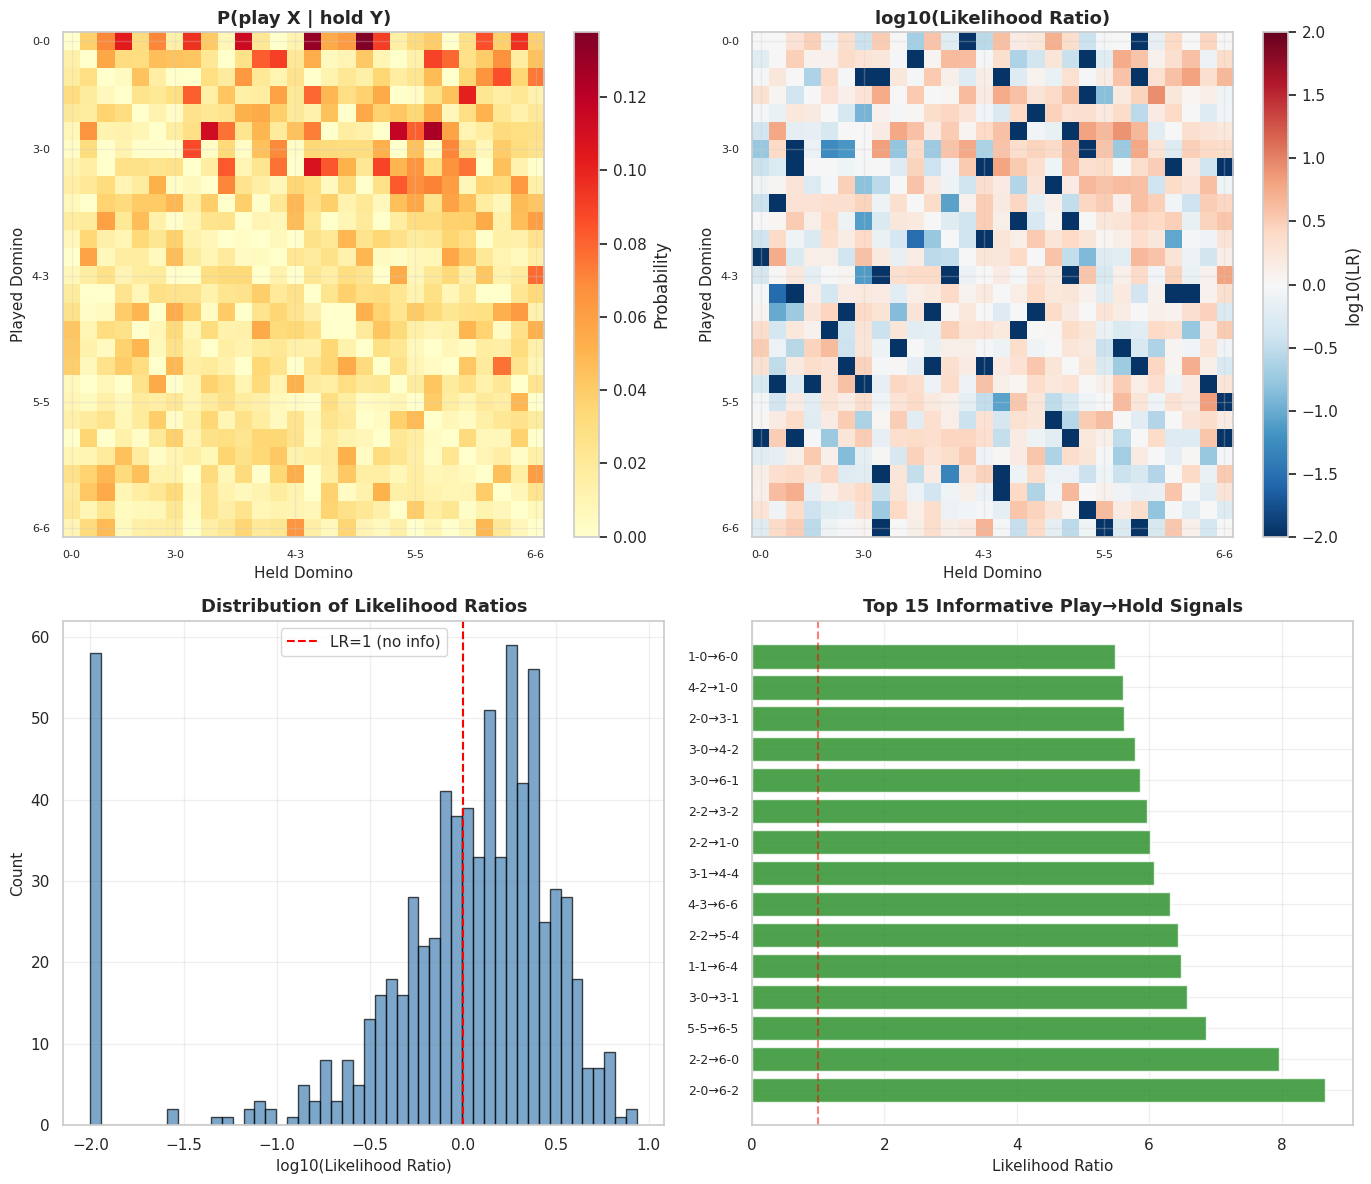

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: P(play X | hold Y) heatmap
ax = axes[0, 0]
domino_labels = [domino_name(d) for d in range(28)]
im = ax.imshow(p_play_given_hold, cmap='YlOrRd', aspect='auto')
ax.set_xlabel('Held Domino', fontsize=11)
ax.set_ylabel('Played Domino', fontsize=11)
ax.set_title('P(play X | hold Y)', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='Probability')
# Add sparse tick labels
tick_positions = [0, 6, 13, 20, 27]
ax.set_xticks(tick_positions)
ax.set_xticklabels([domino_labels[i] for i in tick_positions], fontsize=8)
ax.set_yticks(tick_positions)
ax.set_yticklabels([domino_labels[i] for i in tick_positions], fontsize=8)

# Plot 2: Likelihood ratio heatmap (log scale)
ax = axes[0, 1]
log_lr = np.log10(likelihood_ratios + 0.001)
im = ax.imshow(log_lr, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
ax.set_xlabel('Held Domino', fontsize=11)
ax.set_ylabel('Played Domino', fontsize=11)
ax.set_title('log10(Likelihood Ratio)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('log10(LR)')
ax.set_xticks(tick_positions)
ax.set_xticklabels([domino_labels[i] for i in tick_positions], fontsize=8)
ax.set_yticks(tick_positions)
ax.set_yticklabels([domino_labels[i] for i in tick_positions], fontsize=8)

# Plot 3: Distribution of likelihood ratios
ax = axes[1, 0]
lr_flat = likelihood_ratios.flatten()
lr_flat = lr_flat[lr_flat != 1.0]  # Exclude diagonal/uninformative
ax.hist(np.log10(lr_flat), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', label='LR=1 (no info)')
ax.set_xlabel('log10(Likelihood Ratio)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Likelihood Ratios', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Top informative pairs
ax = axes[1, 1]
top_pairs = informative_df.head(15)
labels = [f"{r['played_name']}→{r['held_name']}" for _, r in top_pairs.iterrows()]
values = top_pairs['likelihood_ratio'].values
colors = ['forestgreen' if v > 1 else 'coral' for v in values]
bars = ax.barh(range(len(labels)), values, color=colors, alpha=0.8)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Likelihood Ratio', fontsize=11)
ax.set_title('Top 15 Informative Play→Hold Signals', fontsize=13, fontweight='bold')
ax.axvline(1, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../../results/figures/25l_opponent_inference.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Create Lookup Table for Live Inference

In [11]:
# Create a practical lookup table: for each play, which holdings become more/less likely?
inference_table = []

for played in range(n_dominoes):
    # Find holdings most suggested by this play
    suggested = [(held, likelihood_ratios[played, held]) 
                 for held in range(n_dominoes) if held != played]
    suggested.sort(key=lambda x: x[1], reverse=True)
    
    # Top 3 positive and top 3 negative
    top_pos = suggested[:3]
    top_neg = suggested[-3:]
    
    inference_table.append({
        'played_id': played,
        'played_name': domino_name(played),
        'suggests_1': domino_name(top_pos[0][0]) if top_pos else '',
        'lr_1': top_pos[0][1] if top_pos else 1.0,
        'suggests_2': domino_name(top_pos[1][0]) if len(top_pos) > 1 else '',
        'lr_2': top_pos[1][1] if len(top_pos) > 1 else 1.0,
        'suggests_3': domino_name(top_pos[2][0]) if len(top_pos) > 2 else '',
        'lr_3': top_pos[2][1] if len(top_pos) > 2 else 1.0,
        'unlikely_1': domino_name(top_neg[-1][0]) if top_neg else '',
        'lr_unlikely_1': top_neg[-1][1] if top_neg else 1.0,
    })

inference_df = pd.DataFrame(inference_table)
print("Inference Lookup Table (sample):")
print(inference_df.head(10).to_string(index=False))

Inference Lookup Table (sample):
 played_id played_name suggests_1     lr_1 suggests_2     lr_2 suggests_3     lr_3 unlikely_1  lr_unlikely_1
         0         0-0        5-2 5.118629        4-4 3.935352        4-0 3.668306        6-1           0.01
         1         1-0        6-0 5.478525        4-1 4.321381        4-2 4.161244        5-4           0.01
         2         1-1        6-4 6.474878        6-6 4.653168        6-3 3.851149        6-1           0.01
         3         2-0        6-2 8.651340        3-1 5.613010        4-4 5.431649        5-4           0.01
         4         2-1        5-2 2.841325        4-1 2.599300        6-3 2.530027        5-1           0.01
         5         2-2        6-0 7.955314        5-4 6.441244        1-0 6.013949        5-3           0.01
         6         3-0        3-1 6.564724        6-1 5.857231        4-2 5.781859        5-4           0.01
         7         3-1        4-4 6.070400        5-3 4.106156        5-0 3.343583        6-6  

## 8. Key Insights

In [12]:
print("\n" + "="*60)
print("KEY INSIGHTS: Opponent Inference Foundation")
print("="*60)

print(f"\n1. DATA SUMMARY:")
print(f"   Total observations: {total_observations:,}")
print(f"   Shards processed: {N_SHARDS}")

print(f"\n2. INFORMATION CONTENT:")
informative_count = np.sum((likelihood_ratios > 1.5) | (likelihood_ratios < 0.67))
total_pairs = n_dominoes * (n_dominoes - 1)
print(f"   Informative pairs (LR > 1.5 or < 0.67): {informative_count} / {total_pairs} ({100*informative_count/total_pairs:.1f}%)")
print(f"   Most extreme positive LR: {likelihood_ratios.max():.2f}")
print(f"   Most extreme negative LR: {likelihood_ratios.min():.4f}")

print(f"\n3. PRACTICAL IMPLICATION:")
print("   Most plays provide weak inference signals (LR close to 1)")
print("   Strong signals exist for specific play-hold pairs")
print("   Foundation for particle filter with Bayesian updates")

print(f"\n4. USAGE IN LIVE PLAY:")
print("   When opponent plays X:")
print("     - Multiply prior P(hold Y) by LR[X, Y]")
print("     - Normalize to get posterior P(hold Y | observed X)")
print("     - Repeat for each observed play")


KEY INSIGHTS: Opponent Inference Foundation

1. DATA SUMMARY:
   Total observations: 415,789
   Shards processed: 10

2. INFORMATION CONTENT:
   Informative pairs (LR > 1.5 or < 0.67): 530 / 756 (70.1%)
   Most extreme positive LR: 8.65
   Most extreme negative LR: 0.0100

3. PRACTICAL IMPLICATION:
   Most plays provide weak inference signals (LR close to 1)
   Strong signals exist for specific play-hold pairs
   Foundation for particle filter with Bayesian updates

4. USAGE IN LIVE PLAY:
   When opponent plays X:
     - Multiply prior P(hold Y) by LR[X, Y]
     - Normalize to get posterior P(hold Y | observed X)
     - Repeat for each observed play


## 9. Save Results

In [13]:
# Save the inference table
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25l_opponent_inference.csv"
inference_df.to_csv(output_path, index=False)
print(f"Saved inference lookup table to {output_path}")

# Also save the full likelihood ratio matrix
lr_output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25l_likelihood_ratios.csv"
lr_df = pd.DataFrame(likelihood_ratios, 
                     index=[domino_name(d) for d in range(28)],
                     columns=[domino_name(d) for d in range(28)])
lr_df.to_csv(lr_output_path)
print(f"Saved full LR matrix to {lr_output_path}")

Saved inference lookup table to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25l_opponent_inference.csv
Saved full LR matrix to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25l_likelihood_ratios.csv


## Key Findings

### Opponent Inference Foundation

Built likelihood ratio table for Bayesian opponent modeling:

1. **P(play X | hold Y)**: Conditional probability matrix from oracle data

2. **Likelihood Ratios**: LR(Y | X) for updating beliefs about opponent holdings

3. **Informative Signals**: Identified which plays provide strong information

### Application for Live Play

During a game, use Bayesian updating:
```
P(hold Y | observed plays) ∝ P(hold Y) × ∏ LR(Y | play_i)
```

This enables particle filter opponent modeling where:
1. Initialize particles with possible opponent hands
2. Weight particles by likelihood given observed plays
3. Resample to focus on likely configurations

### Output Files

- `results/tables/25l_opponent_inference.csv` - Per-domino inference lookup
- `results/tables/25l_likelihood_ratios.csv` - Full 28×28 LR matrix
- `results/figures/25l_opponent_inference.png` - Visualization